In [1]:
from src.training.model import TransformerClassifier
import pandas as pd

from sklearn.model_selection import train_test_split
from src.utils import load_config

In [2]:
# Load config
env = "prod"
model_type = "BERT"

training_config = load_config(
    file_name="training_config", env=env, folder="../../config"
)

# Load the data

In [3]:
df = pd.read_parquet("../../output_data/prod/temp_supervised_dataset_1.parquet")

In [4]:
df.sample(10)

,codigo,id_pieza,CODART_A3,CAR3,text_to_analyse,processed_text_to_analyse,label,similarity_prediction,Ground_truth
17506,LPEZMPDL0E,84068,AZCE6THINKRN,91,LAS BATERÍAS DEBEN REEMPLAZARSE REGULARMENTE T...,baterias reemplazarse regularmente termostato ...,0,303,301
16823,MZGXM5VM5C,81244,AZCE6THINKRB,91,TRAS CAMBIO DEE LA CENTRALITA EL MANDO NO REPO...,cambio dee centralita mando reponde retiro pil...,0,303,301
5336,Z2PQZ2LW03,44599,AZDI6BLUEFACECB,91,BLUEFACE SE HA QUEDADO NEGRTO Y NO RESPONDE CA...,blueface quedado negrto responde cara azul blu...,0,303,301
12862,MJKBNZPH7B,67454,AZCE6BLUEZEROCB,91,los termostatos no responden a ninguna pulsaci...,termostatos responden pulsacion bloqueados env...,0,301,301
2918,LWZPM2XR31,37992,AZCE6BLUEFACECB,91,línea vertical en entintado CARA AZUL LÍNEA VE...,linea vertical entintado cara azul linea verti...,1,303,303
957,L2LTLMDQB5,32637,AZCE6THINKRB,91,AL TERMOSTATO SE LE HA DESPEGADO LA PANTALLA. ...,termostato despegado pantalla pensar termostat...,1,303,303
4448,BMLLBM1SE8,42275,AZCE6BLUEFACECB,91,LÍNEA ROJA VERTICAL EN EL CENTRO DE LA PANTALL...,linea roja vertical centro pantalla linea roja...,1,303,303
18440,NWJXZMTO7C,87618,AZCE6THINKRB,91,La pantalla no enciende La pantalla no enciende,pantalla enciende pantalla enciende,1,303,303
2246,LGVQMWXT8E,36119,AZCE6BLUEFACECB,91,Hay dos termostatos Blueface que no funcionan ...,termostatos blueface funcionan azce6bluefacecb...,1,303,303
15747,LPGXLPZIA9,77619,AZCE6BLUEZEROCB,91,EL TERMOSTATO SE BLOQUEA Termostato cable Airz...,termostato bloquea termostato cable airzone bl...,0,301,301


In [5]:
X = df[["processed_text_to_analyse", "label"]]

In [6]:
X.shape

(1395, 2)

In [7]:
X["label"].value_counts()

label
0    781
1    614
Name: count, dtype: int64

In [8]:
num_labels = X["label"].nunique()

# Split the data

In [137]:
X_train, X_test, y_train, y_test = train_test_split(
    #X.drop(columns=[training_config.training[model_type].target]),
    X[training_config.training[model_type].features],
    X[training_config.training[model_type].target],
    test_size=training_config.training[model_type].test_size,
    random_state=training_config.training.random_state,
    stratify=X[training_config.training[model_type].target],
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=training_config.training[model_type].val_size,
    random_state=training_config.training.random_state,
    stratify=y_train,
)
X_test, X_cp, y_test, y_cp = train_test_split(
    X_test,
    y_test,
    test_size=training_config.training[model_type].cp_size,
    random_state=training_config.training.random_state,
    stratify=y_test,
)

In [48]:
X_train.shape, X_val.shape, X_test.shape, X_cp.shape

((889,), (157,), (174,), (175,))

In [49]:
# Upsample the minority class
from sklearn.utils import resample

X_upsampled = X_train.copy().to_frame()
X_upsampled[training_config.training[model_type].target] = y_train

# Separate majority and minority classes
df_majority = X_upsampled[X_upsampled[training_config.training[model_type].target]==0]
df_minority = X_upsampled[X_upsampled[training_config.training[model_type].target]==1]

# Upsample minority class
df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=df_majority.shape[0],
    random_state=42,
)

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
X_train = df_upsampled[training_config.training[model_type].features]
y_train = df_upsampled[training_config.training[model_type].target]

In [50]:
y_train.value_counts()

label
0    498
1    498
Name: count, dtype: int64

In [51]:
y_val.value_counts()

label
0    88
1    69
Name: count, dtype: int64

In [52]:
y_test.value_counts()

label
0    97
1    77
Name: count, dtype: int64

In [53]:
y_cp.value_counts()

label
0    98
1    77
Name: count, dtype: int64

# Train the model

In [54]:
clf = TransformerClassifier(
    model_name="dtorber/bert-base-spanish-wwm-cased_K4",
    num_labels=num_labels,
)

In [55]:
# Train the model
clf.fit(X=X_train, y=y_train, eval_X=X_val, eval_y=y_val, freeze_layers_prefix=["bert.embeddings", "bert.encoder"])

Epoch,Training Loss,Validation Loss
1,0.318100,0.174469
2,0.125600,0.181311
3,0.221900,0.249435
4,0.013100,0.263582
5,0.022500,0.262949
6,0.068100,0.324777


ValueError: could not determine the shape of object type 'Series'

In [57]:
clf.model.save_pretrained("../../output_models/prod/temp_model")
clf.tokenizer.save_pretrained("../../output_models/prod/temp_model")

('../../output_models/prod/temp_model\\tokenizer_config.json',
 '../../output_models/prod/temp_model\\special_tokens_map.json',
 '../../output_models/prod/temp_model\\vocab.txt',
 '../../output_models/prod/temp_model\\added_tokens.json',
 '../../output_models/prod/temp_model\\tokenizer.json')

In [58]:
clf = TransformerClassifier(
    model_name=None,
    num_labels=num_labels,
    local_model_path="../../output_models/prod/temp_model"
)

In [68]:
# Evaluate the model
from sklearn.metrics import classification_report

val_texts_list = X_test.tolist()  # Convert to a list if necessary
predictions = clf.predict(val_texts_list)

In [69]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.93      0.80      0.86        97
           1       0.79      0.92      0.85        77

    accuracy                           0.86       174
   macro avg       0.86      0.86      0.86       174
weighted avg       0.87      0.86      0.86       174


In [74]:
# Create a dataframe with the predictions
df_predictions = pd.DataFrame(
    {
        "text_to_analyse": X_test,
        "label": y_test,
        "prediction": predictions,
    }
)
df_predictions

,text_to_analyse,label,prediction
16331,termostato ibpro6 monocromo airzone think radi...,0,0
17238,azce6thinkrb sn f016f87 permanece atascado bat...,0,0
1007,funcionan blueface pantalla bloqueada pantalla...,1,1
7085,pantalla termostato congela pone roja remoto c...,0,0
170,pantalla queda blanco pantalla queda blanco,1,1
...,...,...,...
6921,vivienda sistema acuazone actualmente termosta...,1,1
4833,pantalla funciona cara azul pantalla funciona,1,1
7556,cara azul pantalla azul entrada 43661,1,1
1634,blueface responde queda pillado termostato car...,0,0


# Conformal prediction

In [75]:
import numpy as np
import matplotlib.pyplot as plt

from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score

In [76]:
# Calculate Softmax score
# softmax_score = np.max(y_pred_proba, axis=1)

# Initialize the Conformal Prediction classifier
mapie_score = MapieClassifier(estimator=clf, cv="prefit", method="score")
mapie_score.fit(X_cp, y_cp)

alpha = [0.2, 0.1, 0.05]
y_pred_score, y_ps_score = mapie_score.predict(X_test, alpha=alpha)

In [107]:
y_ps_score.shape

(389, 2, 1)

In [139]:
teste = pd.concat([X_test.copy(), y_test.copy()], axis=1)
teste["outlier"] = False
if y_ps_score is not None:
    for i in range(len(teste)):
        label_boolean = y_ps_score[i, :, 0]
        set_size = np.sum(label_boolean)
        if set_size > 1:
            teste.loc[df.index[i], "outlier"] = True

In [77]:
def plot_scores(n, alphas, scores, quantiles):
    colors = {0: "#1f77b4", 1: "#ff7f0e", 2: "#2ca02c"}
    plt.figure(figsize=(7, 5))
    plt.hist(scores, bins="auto")
    for i, quantile in enumerate(quantiles):
        plt.vlines(
            x=quantile,
            ymin=0,
            ymax=100,
            color=colors[i],
            ls="dashed",
            label=f"alpha = {alphas[i]}",
        )
    plt.title("Distribution of scores")
    plt.legend()
    plt.xlabel("Scores")
    plt.ylabel("Count")
    plt.show()

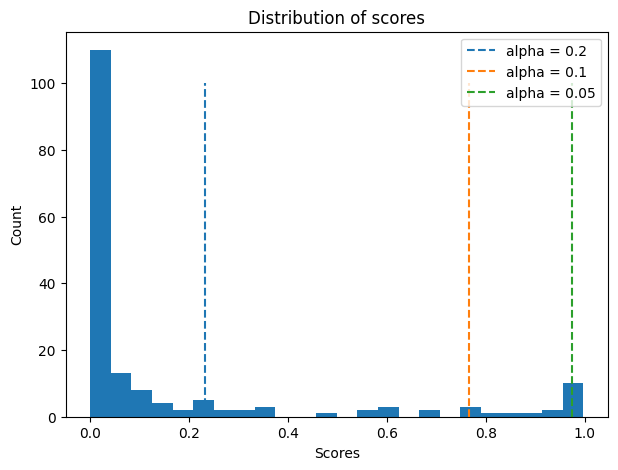

In [78]:
scores = mapie_score.conformity_scores_
n = len(mapie_score.conformity_scores_)
quantiles = mapie_score.quantiles_

plot_scores(n, alpha, scores, quantiles)

In [86]:
"""
    0: 301 - Bloqueado
    1: 303 - Pantalla
"""
df2 = pd.read_parquet("../../output_data/prod/temp_supervised_dataset_2.parquet")
teste = clf.predict_proba(df2[df2["label"]==2]["processed_text_to_analyse"])

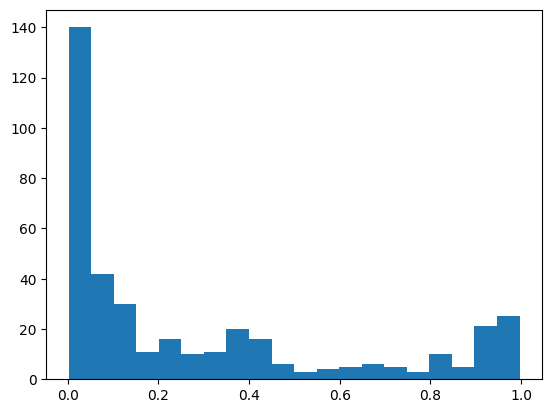

In [87]:
# Plot hist
plt.hist(teste[:,1], bins=20)
plt.show()

In [95]:
(teste[0]>0.1) & (teste[0]<0.9) & (teste[1]>0.1) & (teste[1]<0.9)

array([False, False])

In [101]:
teste.shape

(389, 2)

In [102]:
teste[(teste[:,0]>0.05) & (teste[:,0]<0.95) & (teste[:,0]>0.05) & (teste[:,0]<0.95)]

array([[0.7487137 , 0.25128636],
       [0.91418964, 0.08581033],
       [0.7632337 , 0.2367663 ],
       [0.6143129 , 0.38568714],
       [0.6476796 , 0.3523203 ],
       [0.89624876, 0.10375124],
       [0.25428477, 0.7457153 ],
       [0.34506223, 0.65493774],
       [0.6557296 , 0.34427038],
       [0.86133194, 0.13866812],
       [0.2995324 , 0.7004676 ],
       [0.2995324 , 0.7004676 ],
       [0.9405509 , 0.05944907],
       [0.94627   , 0.05372995],
       [0.7943125 , 0.20568748],
       [0.06860282, 0.93139714],
       [0.938235  , 0.061765  ],
       [0.9071637 , 0.09283628],
       [0.85309315, 0.14690687],
       [0.8915132 , 0.10848675],
       [0.13525353, 0.86474645],
       [0.5088101 , 0.4911899 ],
       [0.77189255, 0.22810741],
       [0.7663893 , 0.23361067],
       [0.7740639 , 0.22593608],
       [0.565413  , 0.434587  ],
       [0.8599302 , 0.14006981],
       [0.56044555, 0.43955442],
       [0.93465436, 0.06534562],
       [0.9290651 , 0.07093485],
       [0.

In [103]:
y_pred_score, y_ps_score = mapie_score.predict(df2[df2["label"]==2]["processed_text_to_analyse"], alpha=0.1)

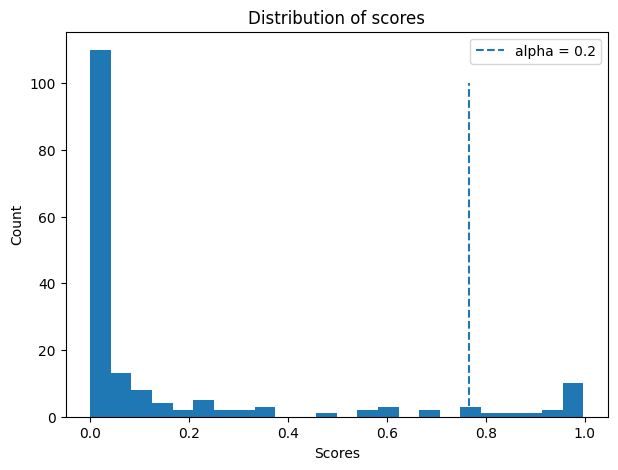

In [104]:
scores = mapie_score.conformity_scores_
n = len(mapie_score.conformity_scores_)
quantiles = mapie_score.quantiles_

plot_scores(n, alpha, scores, quantiles)